## A simple demostration of how to run

In [4]:
# before import, make sure FaceBoxes and Sim3DR are built successfully, e.g.,
# sh build.sh

import cv2
import yaml

from FaceBoxes import FaceBoxes
from TDDFA import TDDFA
from utils.functions import draw_landmarks
from utils.render import render
from utils.depth import depth

import matplotlib.pyplot as plt

### Load configs

In [2]:
# load config
cfg = yaml.load(open('configs/mb1_120x120.yml'), Loader=yaml.SafeLoader)

# Init FaceBoxes and TDDFA, recommend using onnx flag
onnx_flag = True  # or True to use ONNX to speed up
if onnx_flag:
    import os
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
    os.environ['OMP_NUM_THREADS'] = '4'
    
    from FaceBoxes.FaceBoxes_ONNX import FaceBoxes_ONNX
    from TDDFA_ONNX import TDDFA_ONNX
    
    face_boxes = FaceBoxes_ONNX()
    tddfa = TDDFA_ONNX(**cfg)
else:
    tddfa = TDDFA(gpu_mode=False, **cfg)
    face_boxes = FaceBoxes()

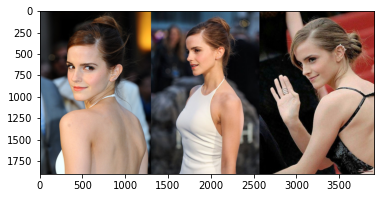

In [3]:
# given an image path
img_fp = 'examples/inputs/emma.jpg'
img = cv2.imread(img_fp)
plt.imshow(img[..., ::-1])

### Detect faces using FaceBoxes

In [15]:
import torch

In [16]:
from BlazeFace.blazeface import BlazeFace
def setup_face_detection():
	device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
	net = BlazeFace().to(device)
	net.load_weights("BlazeFace/blazeface.pth")
	net.load_anchors("BlazeFace/anchors.npy")
	# Optionally change the thresholds:
	net.min_score_thresh = 0.75
	net.min_suppression_threshold = 0.3
	return net

fa_detection = setup_face_detection()

In [ ]:
face_boxes

In [4]:
# face detection
boxes = face_boxes(img)
print(f'Detect {len(boxes)} faces')
print(boxes)

ValueError: Buffer dtype mismatch, expected 'int64_t' but got 'long'

In [5]:
boxes = [[1699.8103, 278.4466, 2057.8765, 762.2303, 0.999949], [2999.4954, 305.0812, 3428.5447, 900.97614, 0.99989545], [317.43112, 399.97055, 792.7798, 1048.0317, 0.99988735]]

### Regressing 3DMM parameters, reconstruction and visualization

In [6]:
# regress 3DMM params
param_lst, roi_box_lst = tddfa(img, boxes)

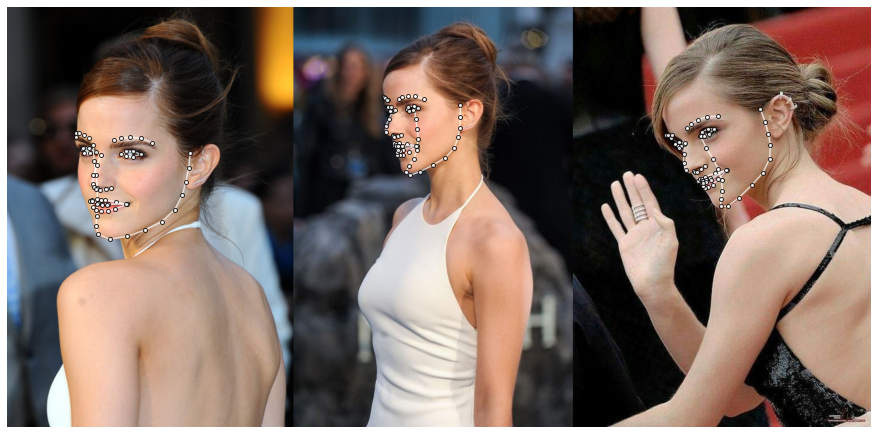

In [7]:
# reconstruct vertices and visualizing sparse landmarks
dense_flag = False
ver_lst = tddfa.recon_vers(param_lst, roi_box_lst, dense_flag=dense_flag)
draw_landmarks(img, ver_lst, dense_flag=dense_flag)

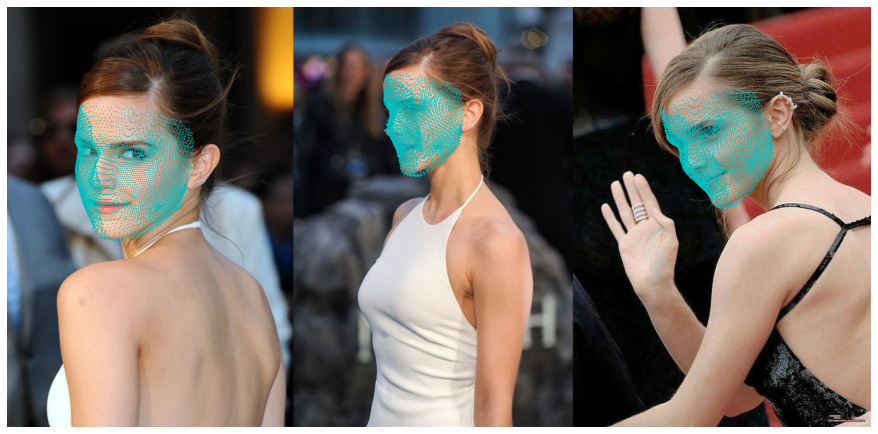

In [8]:
# reconstruct vertices and visualizing dense landmarks
dense_flag = True
ver_lst = tddfa.recon_vers(param_lst, roi_box_lst, dense_flag=dense_flag)
draw_landmarks(img, ver_lst, dense_flag=dense_flag)

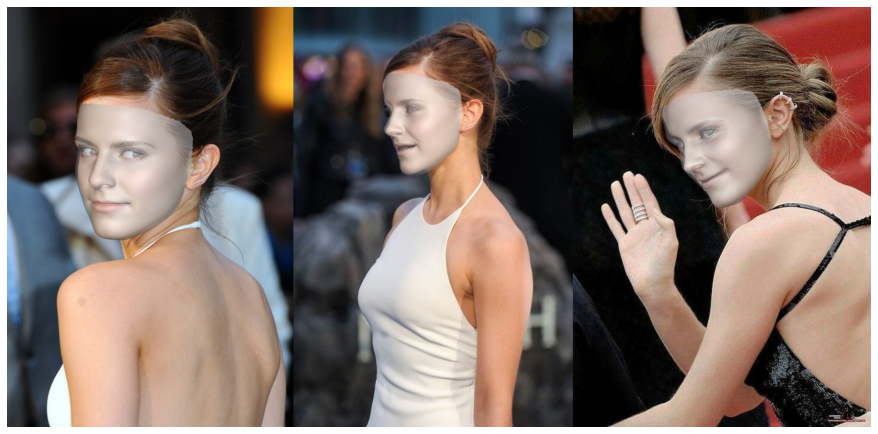

In [9]:
# reconstruct vertices and render
ver_lst = tddfa.recon_vers(param_lst, roi_box_lst, dense_flag=dense_flag)
render(img, ver_lst, tddfa.tri, alpha=0.6, show_flag=True);

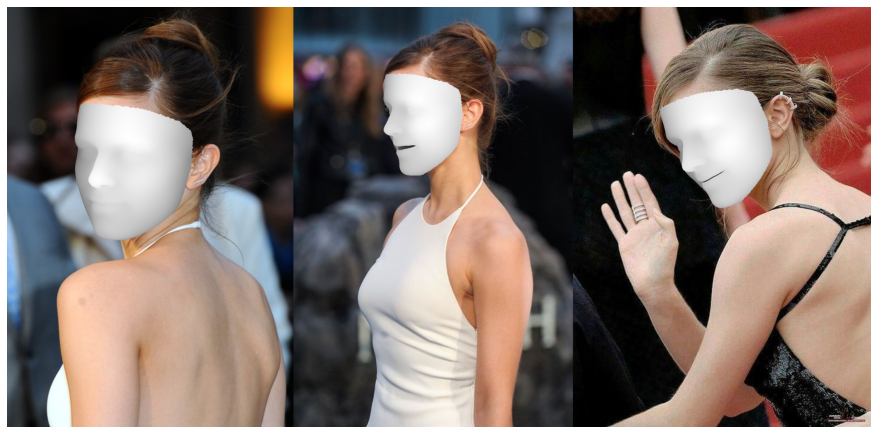

In [10]:
# reconstruct vertices and render depth
ver_lst = tddfa.recon_vers(param_lst, roi_box_lst, dense_flag=dense_flag)
depth(img, ver_lst, tddfa.tri, show_flag=True);